# Simulating Complex Physics with Graph Networks: step by step

## Overview

• By Peng Chen, Shiyu Li, Haochen Shi as part of Stanford CS224W course project. 

• This tutorial provides a step-by-step guide for how to build a Graph Network to simulate complex physics.

**Before we get started:**
- This Colab includes a concise PyG implementation of paper ***Learning to Simulate Complex Physics with Graph Networks*.
- We adapted our code from open-source tensorflow implementation by DeepMind.
    - Link to pdf of this paper: https://arxiv.org/abs/2002.09405
    - Link to Deepmind's implementation: https://github.com/deepmind/deepmind-research/tree/master/learning_to_simulate
    - Link to video site by DeepMind: https://sites.google.com/view/learning-to-simulate
- Run **sequentially run all cells in each section**, so intermediate variables / packages will carry over to next cell.


## Device

We recommend using a GPU for this Colab. Click `Runtime` then `Change runtime type`. Then set `hardware accelerator` to **GPU**.

## Setup

installation of PyG on Colab can be a little bit tricky. Before we get started, let's check which version of PyTorch you are running.

In [1]:
#!pip install rectpack

In [2]:
# import re

# def identify_text(text):
#     # Define a regex pattern to extract the text between the timestamp and newline
#     pattern = r"\[\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\] - (.*?)\n"
    
#     # Search for the pattern in the text
#     match = re.search(pattern, text)
    
#     if match:
#         # Extract the text between the timestamp and newline
#         extracted_text = match.group(1)
#         # print(extracted_text)
#     else:
#         # print("Pattern not found")

# # Sample texts
# text1 = "[2024-08-31 15:38:16] - rollout_path\ntemp/rollouts/WaterDrop"
# text2 = "[2024-08-31 15:38:17] - self.metadata - OneStepDataset\nLength:9\nType:<class 'dict'>..."

# # Test the function
# identify_text(text1)  # Should print "rollout_path"
# identify_text(text2)  # Should print "self.metadata - OneStepDataset"

In [3]:
# Dataset Source #1:
# https://drive.google.com/file/d/1ZmiKpsQVLFxPOIff-LfFkZwe5ZYG1FEb/view?usp=drive_link

# Dataset Source #2:
# https://drive.google.com/drive/mobile/folders/11uuYl0peqPg2DQno64YPYMODPu8fjDXU?usp=sharing

In [4]:
#!pip install torch

In [5]:
!export LD_LIBRARY_PATH=/home/admin1/anaconda3/envs/GNN/lib:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/lib/x86_64-linux-gnu:$LD_LIBRARY_PATH    

In [6]:
import random
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
imageindex = 0

In [7]:
import re

def remove_timestamp(log_entry):
    # Use regex to match the timestamp pattern and remove it
    cleaned_entry = re.sub(r'\[\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\] - ', '', log_entry)
    return cleaned_entry

def text_to_image_function(text, font_size, output_file, selected_font_name):
    # Remove timestamp
    text = remove_timestamp(text)

    # Define the initial image size and other properties
    initial_max_width = 640
    initial_max_height = 640
    background_color = "white"
    text_color = "black"
    border_color = "black"
    padding = 20
    border_width = 1

    # Initialize variables for the actual size
    required_width = initial_max_width
    required_height = initial_max_height

    # Load the font
    font = ImageFont.truetype(selected_font_name, font_size)

    # Create a temporary image to measure the text size
    temp_image = Image.new("RGB", (initial_max_width, initial_max_height), background_color)
    draw = ImageDraw.Draw(temp_image)
    
    # Measure the text size
    text_size = draw.textsize(text, font=font)
    #text_size = draw.textbbox((0, 0), text, font=font)

    # Calculate the required size based on the measured text size
    required_width = text_size[0] + 2 * (padding + border_width)
    required_height = text_size[1] + 2 * (padding + border_width)

    # Ensure the image is not smaller than the initial size
    required_width = max(required_width, initial_max_width)
    required_height = max(required_height, initial_max_height)

    # Create the final image with the calculated size
    image = Image.new("RGB", (required_width, required_height), background_color)
    draw = ImageDraw.Draw(image)

    # Draw the text on the image
    text_position = (padding, padding)
    draw.text(text_position, text, fill=text_color, font=font)

    # Draw a border around the text
    border_rectangle = [
        padding - border_width, 
        padding - border_width, 
        padding + text_size[0] + border_width, 
        padding + text_size[1] + border_width
    ]
    draw.rectangle(border_rectangle, outline=border_color, width=border_width)

    border_rectangle1 = [
        padding - border_width, 
        padding - border_width, 
        padding + text_size[0] + border_width + 1, 
        padding + text_size[1] + border_width + 1
    ]
    
    # Crop the image to the size of the border
    cropped_image = image.crop(border_rectangle1)

    # Save the cropped image
    cropped_image.save(output_file, "PNG")

    # Optionally, copy the cropped image to the clipboard (requires `pyperclip` and `Pillow` integration)
    # pyperclip.copy(cropped_image)  # Not directly supported; requires custom implementation
    
    

In [8]:
import os
import torch
# print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

• Download necessary packages for PyG. 

• ensure your version of torch matches output from cell above. 

• In case of any issues, more information may be found on [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html)

!pip3 install torch==1.12.1+cu102 torchvision==0.13.1+cu102 torchaudio==0.12.1 torchtext --extra-index-url https://download.pytorch.org/whl/cu102

!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_cluster-1.6.0%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl

!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_scatter-2.1.0%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl

!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_sparse-0.6.16%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl

!pip install torch-geometric

!pip install matplotlib

!pip install networkx


# Dataset Preparation
!cd /home/admin1/Desktop/gnndataset/datasets/WaterDrop/

# metadata.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1o6cKxgbnfUUFPTX1JngBzB928w2bUIwk' -O metadata.json

# test_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vr4JiVliKCQNWVV4kziyusxNVUvQuAYL' -O test_offset.json

# test_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Z_r9ivdKqKZzVJG80gb2uY6JDVRd0wAt' -O test_particle_type.dat

# test_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wCeBz1pZ5hxmlqWw4eylajg6pzFgQjIJ' -O test_position.dat

# train_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=160wnp9PEc1HuzsBi7kO0ryMu3tnon2tI' -O train_offset.json

# train_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LVtGLld7assF4sPk0mF2Bz2F7FBaxU0O' -O train_particle_type.dat

# train_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YCXcir_fmJZLvXkbPjchsrr8VuuWugH0' -O train_position.dat

# valid_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tiDP5uHMJQDTNxyRNSb6sEZCWAADPu8a' -O valid_offset.json

# valid_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fXIw9RWM0xzfK2sGn1H0DaAOxzm59ZEd' -O valid_particle_type.dat

# valid_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1U9QuV3Ra0E1tDD1HgXYCYyn4SeLKXQGs' -O valid_position.dat


## Dataset

• Dataset WaterDropSmall includes 100 videos of dropping water to ground rendered in a particle-based physics simulator. 

• It is a cropped version of WaterDrop dataset by Deepmind. 

• will download this dataset from Google Cloud stoarge to folder `temp/datasets` in file system. 

• may inspect downloaded files on **Files** menu on left of this Colab.

`metadata.json` file in dataset includes following information:
1. sequence length of each video data point
2. dimensionality, 2d or 3d
3. box bounds - specify bounding box for scene
4. default connectivity radius - defines size of each particle's neighborhood
5. statistics for normalization e.g. velocity mean and standard deviation and acceleration of particles


Each data point in dataset includes following information:
1. Particle type, such as water
2. particle positions at each frame in video

In [9]:
from datetime import datetime
import inspect
import os

# Global flags to enable/disable debugging and verbosity
DEBUG_ENABLED = True
VERBOSE_ENABLED = False

# Global dictionary to store logged headers and their counts
logged_header_counts = {}
folders_created = []  # Initialize an empty list

def debug_log(theVariable, functionName=None, ShowShape=False, ShowLength=False, ShowType=False, ExplicitVariableName=None):
    
    # print("#################", flush=True)
    # print("## theVariable ##", flush=True)
    # print("#################", flush=True)
    # print(theVariable, flush=True)
    # print("", flush=True)    
    
    global logged_header_counts  # Access the global dictionary
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    frame = inspect.currentframe().f_back
    variable_names = [name for name, val in frame.f_locals.items() if val is theVariable]
    theVariableName = variable_names[0] if variable_names else ExplicitVariableName

    # print("#####################", flush=True)
    # print("## theVariableName ##", flush=True)
    # print("#####################", flush=True)
    # print(theVariableName, flush=True)
    # print("", flush=True)    
    
    thefilename = ''
    if functionName is not None:
        functionName = functionName.replace("\\", "_")

    if DEBUG_ENABLED:
        
        if ExplicitVariableName is None:
            # INCLUDE functionName
            if functionName:
                header = f"{theVariableName} - {functionName}"
                log_message = f"{timestamp} {header}\n"
                thefilename = header
            else:
                # EXCLUDE functionName
                header = f"{theVariableName}"
                log_message = f"{timestamp} {header}\n"
                thefilename = header
        else:
                header = ExplicitVariableName
                log_message = f"{timestamp} {header}\n"
                thefilename = header


        # print("############", flush=True)
        # print("## header ##", flush=True)
        # print("############", flush=True)
        # print(header, flush=True)
        # print("", flush=True)

            
        # Check if the header has been logged less than 2 times
        if header in logged_header_counts:
            if logged_header_counts[header] >= 1:
            # if logged_header_counts[header] >= 2:
                return  # Skip logging if the header has been logged twice
            else:
                logged_header_counts[header] += 1  # Increment the count
        else:
            logged_header_counts[header] = 1  # Add new header to the dictionary with a count of 1

        #if ShowShape:
        #            log_message += "Shape:" + str(theVariable.shape) + "\n"
        if ShowShape:
            if hasattr(theVariable, 'shape'):
                log_message += "Shape:" + str(theVariable.shape) + "\n"
            else:
                log_message += "Shape: Not applicable\n"

        
        # if ShowLength:
        #     if isinstance(theVariable, torch.Tensor):
        #         if theVariable.dim() == 1:
        #             log_message += "Length:" + str(len(theVariable)) + "\n"
        #         else:
        #             length = theVariable.numel()
        #             log_message += "Length:" + str(length) + "\n"
        #     else:
        #         log_message += "Length:" + str(len(theVariable)) + "\n"

        if ShowLength:
            try:
                if isinstance(theVariable, torch.Tensor):
                    if theVariable.dim() == 1:
                        log_message += "Length:" + str(len(theVariable)) + "\n"
                    else:
                        length = theVariable.numel()  # Total number of elements
                        log_message += "Length:" + str(length) + "\n"
                else:
                    log_message += "Length:" + str(len(theVariable)) + "\n"
            except (TypeError, AttributeError):
                log_message += "Length: Not applicable\n"

        
        # if ShowType:
        #     if isinstance(theVariable, torch.Tensor):
        #         log_message += "Type:" + str(theVariable.dtype) + "\n"
        #     else:
        #         log_message += "Type:" + str(type(theVariable)) + "\n"

        if ShowType:
            if isinstance(theVariable, torch.Tensor):
                if hasattr(theVariable, 'dtype'):
                    log_message += "Type:" + str(theVariable.dtype) + "\n"
                else:
                    log_message += "Type: No dtype attribute\n"
            else:
                log_message += "Type:" + str(type(theVariable)) + "\n"

        
        # VARIABLE CONTENTS
        log_message += str(theVariable) + "\n"

        # Create an image
        global imageindex
        imageindex = imageindex + 1
        thefilename = thefilename.replace("\\", "_")
        text = log_message
        # Create the folder if it does not exist
        # print("##################", flush=True)
        # print("## functionName ##", flush=True)
        # print("##################", flush=True)
        # print(functionName, flush=True)
        # print("", flush=True)

        # print("#################", flush=True)
        # print("## thefilename ##", flush=True)
        # print("#################", flush=True)
        # print(thefilename, flush=True)
        # print("", flush=True)

        # Create Folder if it does nto exist
        os.makedirs("outputpng", exist_ok=True)
        os.makedirs(r"outputpng/" + str(functionName), exist_ok=True)
        
        folder_path = str(functionName)
        # Append the string only if it doesn't already exist in the list
        if folder_path not in folders_created:
            folders_created.append(folder_path)
            
        output_file = os.path.join(r"outputpng", str(functionName), f"{imageindex:07d} {thefilename}.png")
        # output_file = os.path.join("outputpng\\" + str(functionName), f"{imageindex:07d}{thefilename}.png")
        text_to_image_function(text, 16, output_file, "/usr/share/fonts/truetype/freefont/Arial.ttf")

        log_message += "---------------------------------------------------------" + "\n"

        # Get the current date and time
        current_date = datetime.now().strftime('%Y-%m-%d')

        # Write to log file
        with open(f'debugGNN_{current_date}.txt', 'a') as file:
            file.write(log_message)

    if VERBOSE_ENABLED:
        # print(timestamp)
        
        if ShowShape:
            # print("Shape:", theVariable.shape)
            pass
        if ShowLength:
            if isinstance(theVariable, torch.Tensor):
                if theVariable.dim() == 1:
                    # print("Length:", str(len(theVariable)), flush=True)
                    pass
                else:
                    length = theVariable.numel()
                    # print("Length:", str(length), flush=True)
                    pass
            else:
                # print("Length:", str(len(theVariable)), flush=True)                    
                pass
        if ShowType:
            if isinstance(theVariable, torch.Tensor):
                # print("Type:", str(theVariable.dtype), flush=True)  
                pass
            else:
                # print("Type:", str(type(theVariable)), flush=True) 
                pass

        # VARIABLE CONTENTS                
        if functionName:
            # print('#' * len("## " + theVariableName + ' ## ' + functionName + " ##"), flush=True)
            # print("## " + theVariableName + ' ## ' + functionName + " ##", flush=True)
            # print('#' * len("## " + theVariableName + ' ## ' + functionName + " ##"), flush=True)            
            # print(str(theVariable), flush=True)
            pass
        else:
            # print('#' * len("## " + theVariableName + " ##"), flush=True)
            # print("## " + theVariableName + " ##", flush=True)
            # print('#' * len("## " + theVariableName + " ##"), flush=True)            
            # print(str(theVariable), flush=True)
            pass

# print(logged_header_counts, flush=True)

In [10]:
from datetime import datetime
import inspect
# Global flags to enable/disable debugging and verbosity
DEBUG_ENABLED = True
VERBOSE_ENABLED = False

def debug_log_old(theVariable, functionName=None, ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName=None):
    
    # print("#################")
    # print("## theVariable ##")
    # print("#################")
    # print(theVariable)
    # print("")

    
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    frame = inspect.currentframe().f_back
    variable_names = [name for name, val in frame.f_locals.items() if val is theVariable]
    # theVariableName = variable_names[0]
    theVariableName = variable_names[0] if variable_names else ExplicitVariableName

    # print("#####################")
    # print("## theVariableName ##")
    # print("#####################")
    # print(theVariableName)
    # print("")

    
#     if theVariableName == "unknown_variable":
#         frame_info = traceback.extract_stack(limit=2)[0]
#         log_message = f"[{timestamp}] - Variable name unknown in {frame_info.filename} at line {frame_info.lineno}\n"
#     else:
#         log_message = f"[{timestamp}] - {theVariableName}\n"
    
    thefilename=''
    if functionName is not None:
        functionName=functionName.replace("\\", "_")
    
    if DEBUG_ENABLED:
        # INCLUDE functionName
        if functionName:
            log_message = f"[{timestamp}] - {theVariableName} - {functionName}\n"
            thefilename = f"{theVariableName} - {functionName}"
        else:
            # EXCLUDE functionName
            log_message = f"[{timestamp}] - {theVariableName}\n"
            thefilename = f"{theVariableName}"
            
        if ShowShape:
            log_message += "Shape:" + str(theVariable.shape) + "\n"
        if ShowLength:
            if isinstance(theVariable, torch.Tensor):
                if theVariable.dim() == 1:
                    log_message += "Length:" + str(len(theVariable)) + "\n"
                else:
                    length = theVariable.numel()
                    log_message += "Length:" + str(length) + "\n"
            else:
                log_message += "Length:" + str(len(theVariable)) + "\n"
        if ShowType:
            if isinstance(theVariable, torch.Tensor):
                log_message += "Type:" + str(theVariable.dtype) + "\n"
            else:
                log_message += "Type:" + str(type(theVariable)) + "\n"

        # VARIABLE CONTENTS
        log_message += str(theVariable) + "\n"

        # Create an image
        global imageindex
        imageindex = imageindex + 1
        thefilename = thefilename.replace("\\", "_")
        text = log_message
        output_file = f"{imageindex:07d} {thefilename}.png"
        # text_to_image_function(text, 12, output_file, "/usr/share/fonts/truetype/freefont/FreeSans.ttf")
        text_to_image_function(text, 16, output_file, "/usr/share/fonts/truetype/freefont/Arial.ttf")

        
        log_message += "---------------------------------------------------------" + "\n"
            
        # Get the current date and time
        current_date = datetime.now().strftime('%Y-%m-%d')
        
        # with open('debugGNN.txt', 'a') as file:
        with open(f'debugGNN_{current_date}.txt', 'a') as file:
            file.write(log_message)

    
    if VERBOSE_ENABLED:
        # print(timestamp)
        
        if ShowShape:
            # print("Shape:", theVariable.shape)
            pass
        if ShowLength:
            if isinstance(theVariable, torch.Tensor):
                if theVariable.dim() == 1:
                    # print("Length:", str(len(theVariable)))
                    pass
                else:
                    length = theVariable.numel()
                    # print("Length:", str(length))
                    pass
            else:
                # print("Length:", str(len(theVariable)))                    
                pass
        if ShowType:
            if isinstance(theVariable, torch.Tensor):
                # print("Type:", str(theVariable.dtype))  
                pass
            else:
                # print("Type:", str(type(theVariable))) 
                pass

        # VARIABLE CONTENTS                
        if functionName:
            # print('#' * len("## " + theVariableName + ' ## ' + functionName + " ##"))
            # print("## " + theVariableName + ' ## ' + functionName + " ##")
            # print('#' * len("## " + theVariableName + ' ## ' + functionName + " ##"))            
            # print(str(theVariable))
            pass
        else:
            # print('#' * len("## " + theVariableName + " ##"))
            # print("## " + theVariableName + " ##")
            # print('#' * len("## " + theVariableName + " ##"))            
            # print(str(theVariable))
            pass

In [11]:
# Example Usage:
abc = 123
debug_log("abc1", "NoFunctionaabbcc", ShowShape=True,ShowLength=True,ShowType=True)
debug_log("abc2", "NoFunctionaabbcc", ShowShape=True,ShowLength=True,ShowType=True)
debug_log("abc3", "NoFunctionaabbcc", ShowShape=True,ShowLength=True,ShowType=True)

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)


In [12]:
# print(logged_header_counts)

In [13]:
def debug_log_special(var):
    # Use inspect to find the variable name in the caller's frame
    frame = inspect.currentframe()
    try:
        caller_locals = frame.f_back.f_locals
        var_name = [name for name, value in caller_locals.items() if value is var]
        var_name = var_name[0] if var_name else "unknown"
    finally:
        del frame  # Clean up the frame to avoid reference cycles

    # Print the variable name and its content
    # print(f"{var_name}: {var}")    
    
    with open('debugGNN1.txt', 'a') as file:
        file.write(f"{var_name}: {var}")


In [14]:
import os
import torch
# print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

DATASET_NAME = "WaterDrop"
OUTPUT_DIR = os.path.join("/home/admin1/Desktop/GNN/gnndataset/datasets/WaterDrop")

debug_log(DATASET_NAME, ShowShape=True, ShowLength=True, ShowType=True)

debug_log(OUTPUT_DIR, ShowShape=True, ShowLength=True, ShowType=True)

# BASE_URL = f"https://storage.googleapis.com/cs224w_course_project_dataset/{DATASET_NAME}"

# !mkdir -p "$OUTPUT_DIR"

# META_DATA_PATH = f"{OUTPUT_DIR}/metadata.json"
# CLOUD_PATH = f"{BASE_URL}/metadata.json"
# !wget -O "$META_DATA_PATH" "$CLOUD_PATH"
# for split in ["test", "train", "valid"]:
#   for suffix in ["offset.json", "particle_type.dat", "position.dat"]:
#       DATA_PATH = f"{OUTPUT_DIR}/{split}_{suffix}"
#       CLOUD_PATH = f"{BASE_URL}/{split}_{suffix}"
#       !wget -O "$DATA_PATH" "$CLOUD_PATH"

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)


## Data Preprocessing

• Cannot apply raw data in dataset to train GNN model directly, so must perform below steps to convert raw data into graphs with descriptive node features and edge features:
1. Apply noise to trajectory to have more diverse training examples
1. Construct graph based on distance between particles
1. Extract node-level features: particle velocities and their distance to boundary
1. Extract edge-level features: displacement and distance between particles

In [15]:
import json
import numpy as np
import torch_geometric as pyg

def generate_noise(position_seq, noise_std):
    """Generate noise for a trajectory"""
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    debug_log(velocity_seq, "generate_noise", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[1]] generate_noise--velocity_seq")


    time_steps = velocity_seq.size(1)
    debug_log(time_steps, "generate_noise", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[2]] generate_noise--time_steps")
    
    velocity_noise = torch.randn_like(velocity_seq) * (noise_std / time_steps ** 0.5)
    debug_log(velocity_noise, "generate_noise", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[3]] generate_noise--velocity-noise1")
    
    velocity_noise = velocity_noise.cumsum(dim=1)
    debug_log(velocity_noise, "generate_noise", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[4]] generate_noise--velocity-noise2")    
    
    position_noise = velocity_noise.cumsum(dim=1)
    debug_log(position_noise, "generate_noise", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[5]] generate_noise--position-noise1")
       
    position_noise = torch.cat((torch.zeros_like(position_noise)[:, 0:1], position_noise), dim=1)
    debug_log(position_noise, "generate_noise", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[6]] generate_noise--position-noise2")
    
    return position_noise


def preprocess(particle_type, position_seq, target_position, metadata, noise_std):
    """Preprocess a trajectory and construct graph"""
    # apply noise to trajectory
    position_noise = generate_noise(position_seq, noise_std)
    debug_log(position_noise, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[7]] preprocess--position_noise")
    
    position_seq = position_seq + position_noise
    debug_log(position_seq, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[8]] preprocess--position_seq")

    # calculate velocities of particles
    recent_position = position_seq[:, -1]
    debug_log(recent_position, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[9]] preprocess--recent_position")
    
    
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    debug_log(velocity_seq, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[10]] preprocess--velocity_seq")
    
    
    # construct graph based on distances between particles
    n_particle = recent_position.size(0)
    debug_log(n_particle, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[11]] preprocess--n_particle")
    
    
    edge_index = pyg.nn.radius_graph(recent_position, metadata["default_connectivity_radius"], loop=True, max_num_neighbors=n_particle)
    debug_log(edge_index, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[12]] preprocess--edge_index")

    
    # node-level features: velocity, distance to boundary
    normal_velocity_seq = (velocity_seq - torch.tensor(metadata["vel_mean"])) / torch.sqrt(torch.tensor(metadata["vel_std"]) ** 2 + noise_std ** 2)
    debug_log(normal_velocity_seq, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[13]] preprocess--normal_velocity_seq")
    
    boundary = torch.tensor(metadata["bounds"])
    debug_log(boundary, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[14]] preprocess--boundary")
        
    distance_to_lower_boundary = recent_position - boundary[:, 0]
    debug_log(distance_to_lower_boundary, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[15]] preprocess--distance_to_lower_boundary")
        
    distance_to_upper_boundary = boundary[:, 1] - recent_position
    debug_log(distance_to_upper_boundary, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[16]] preprocess--distance_to_upper_boundary")
    
    distance_to_boundary = torch.cat((distance_to_lower_boundary, distance_to_upper_boundary), dim=-1)
    debug_log(distance_to_boundary, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[17]] preprocess--distance_to_boundary1")    
    
    
    distance_to_boundary = torch.clip(distance_to_boundary / metadata["default_connectivity_radius"], -1.0, 1.0)
    debug_log(distance_to_boundary, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[18]] preprocess--distance_to_boundary2")
    
    

    # edge-level features: displacement, distance
    dim = recent_position.size(-1)
    debug_log(dim, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[19]] dim-preprocess")
    
    edge_displacement = (torch.gather(recent_position, dim=0, index=edge_index[0].unsqueeze(-1).expand(-1, dim)) - torch.gather(recent_position, dim=0, index=edge_index[1].unsqueeze(-1).expand(-1, dim)))
    debug_log(edge_displacement, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[20]] preprocess--edge_displacement1")    
    
    
    edge_displacement /= metadata["default_connectivity_radius"]
    debug_log(edge_displacement, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[21]] preprocess--edge_displacement2")
    
    
    edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)
    debug_log(edge_distance, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[22]] preprocess--edge_distance")    


    
    # ground truth for training
    if target_position is not None:
        last_velocity = velocity_seq[:, -1]
        debug_log(last_velocity, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[23]] preprocess--last_velocity")        
       
        
        next_velocity = target_position + position_noise[:, -1] - recent_position
        debug_log(next_velocity, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[24]] preprocess--next_velocity")        
        
        
        
        acceleration = next_velocity - last_velocity
        debug_log(acceleration, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[25]] preprocess--acceleration1")
        
        
        
        acceleration = (acceleration - torch.tensor(metadata["acc_mean"])) / torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2)
        debug_log(acceleration, "preprocess", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[26]] preprocess--acceleration2")
        
        
        
    else:
        acceleration = None

    # return graph with features
    graph = pyg.data.Data(
        x=particle_type,
        edge_index=edge_index,
        edge_attr=torch.cat((edge_displacement, edge_distance), dim=-1),
        y=acceleration,
        pos=torch.cat((velocity_seq.reshape(velocity_seq.size(0), -1), distance_to_boundary), dim=-1)
    )
    return graph

/home/admin1/anaconda3/envs/GNN/lib/python3.10/site-packages/torch_cluster/nearest.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  import scipy.cluster


### One Step Dataset

• Each datapoint in this dataset contains trajectories sliced to short time windows. 

• We use this dataset in training phase because history of particles' states are necessary for model to make predictions. 

• But in meantime, since long-horizon prediction is inaccurate and time-consuming, sliced trajectories to short time windows to improve perfomance of model.

In [16]:
class OneStepDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7, noise_std=0.0, return_pos=False):
        super().__init__()

        debug_log(data_path, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[27]] OneStepDataset--_init_--data_path")

        
        # load dataset from disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
            debug_log(self.metadata, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[28]] OneStepDataset--_init_--self.metadata")
            
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)
            # debug_log(self.offset, "OneStepDataset 1", ShowShape=True, ShowLength=True, ShowType=True)        
            debug_log(self.offset, "OneStepDataset 1", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[29]] OneStepDataset--_init_--self.offset1")
            
            
        self.offset = {int(k): v for k, v in self.offset.items()}
        # debug_log(self.offset, "OneStepDataset 2", ShowShape=True, ShowLength=True, ShowType=True)        
        debug_log(self.offset, "OneStepDataset 2", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[30]] OneStepDataset--_init_--self.offset2")
        
        
        self.window_length = window_length
        debug_log(window_length, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[31]] OneStepDataset--_init_--window_length")
        
        
        
        self.noise_std = noise_std
        debug_log(noise_std, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[32]] OneStepDataset--_init_--noise_std")

        
        self.return_pos = return_pos
        debug_log(return_pos, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[33]] OneStepDataset--_init_--return_pos")
        
        

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        # debug_log(self.particle_type, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True)
        debug_log(self.particle_type, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[34]] OneStepDataset--_init_--self.particle_type")
        
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")
        # debug_log(self.position, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True)
        debug_log(self.position, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[35]] OneStepDataset--_init_--self.position")
        
        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            # debug_log(self.dim, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True)
            debug_log(self.dim, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[36]] OneStepDataset--_init_--self.dim")
            
            break

        # cut particle trajectories according to time slices
        self.windows = []
        for traj in self.offset.values():
            size = traj["position"]["shape"][1]
            debug_log(size, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[37]] OneStepDataset--traj--size")
            
            length = traj["position"]["shape"][0] - window_length + 1
            debug_log(length, "OneStepDataset", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[38]] OneStepDataset--traj--length")
            
            
            
            for i in range(length):
                desc = {
                    "size": size,
                    "type": traj["particle_type"]["offset"],
                    "pos": traj["position"]["offset"] + i * size * self.dim,
                }
                self.windows.append(desc)

    def len(self):
        return len(self.windows)

    def get(self, idx):
        # load corresponding data for this time slice
        window = self.windows[idx]
        debug_log(window, "get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[39]] OneStepDataset--get--window")
        
        
        size = window["size"]
        debug_log(size, "get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[40]] OneStepDataset--get--size")
        
        
        particle_type = self.particle_type[window["type"]: window["type"] + size].copy()
        debug_log(particle_type, "get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[41]] OneStepDataset--get--particle_type1")
                
        
        particle_type = torch.from_numpy(particle_type)
        debug_log(particle_type, "get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[42]] OneStepDataset--get--particle_type2")
        
        
        position_seq = self.position[window["pos"]: window["pos"] + self.window_length * size * self.dim].copy()
        debug_log(position_seq, "get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[43]] OneStepDataset--get--position_seq1")
        
        position_seq.resize(self.window_length, size, self.dim)
        debug_log(position_seq, "get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[44]] OneStepDataset--get--position_seq2")
        
        position_seq = position_seq.transpose(1, 0, 2)
        debug_log(position_seq, "get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[45]] OneStepDataset--get--position_seq3")
        
        target_position = position_seq[:, -1]
        debug_log(target_position, "get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[46]] OneStepDataset--get--target_position1")
        
        
        position_seq = position_seq[:, :-1]
        debug_log(position_seq, "get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[47]] OneStepDataset--get--position_seq4")
        
        target_position = torch.from_numpy(target_position)
        debug_log(target_position, "get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[48]] OneStepDataset--get--target_position2")
        
        
        position_seq = torch.from_numpy(position_seq)
        debug_log(position_seq, "get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[49]] OneStepDataset--get--position_seq5")
        

        # construct graph
        with torch.no_grad():
            graph = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise_std)
        if self.return_pos:
            return graph, position_seq[:, -1]
        return graph

### Rollout Dataset

• Each datapoint in this dataset contains trajectories of particles over 1000 time frames. 

• This dataset used in evaluation phase to measure model's ability to make long-horizon predictions.

In [17]:
class RolloutDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7):
        super().__init__()

        # load data from disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
            # debug_log(self.metadata, "RolloutDataset\_init_", ShowShape=True, ShowLength=True, ShowType=True)
            debug_log(self.metadata, "RolloutDataset\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[50]] RolloutDataset--_init_--self.metadata")
            
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)
            # debug_log(self.offset, "RolloutDataset\_init_", ShowShape=True, ShowLength=True, ShowType=True)
            debug_log(self.offset, "RolloutDataset\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[51]] RolloutDataset1--_init_--self.offset")
            
        self.offset = {int(k): v for k, v in self.offset.items()}
        # debug_log(self.offset, "RolloutDataset\_init_", ShowShape=True, ShowLength=True, ShowType=True)
        debug_log(self.offset, "RolloutDataset\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[52]] RolloutDataset2--_init_--self.offset")
        
        self.window_length = window_length
        debug_log(window_length, "RolloutDataset\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[53]] RolloutDataset--_init_--window_length")
        
        

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        # debug_log(self.particle_type, "RolloutDataset\_init_", ShowShape=True, ShowLength=True, ShowType=True)
        debug_log(self.particle_type, "RolloutDataset\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[54]] RolloutDataset--_init_--self.particle_type")
        
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")
        # debug_log(self.position, "RolloutDataset\_init_", ShowShape=True, ShowLength=True, ShowType=True)
        debug_log(self.position, "RolloutDataset\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[55]] RolloutDataset--_init_--self.position")
        
        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            break

    def len(self):
        return len(self.offset)

    def get(self, idx):
        traj = self.offset[idx]
        debug_log(traj, "RolloutDataset\get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[56]] RolloutDataset--get--traj")
        
        size = traj["position"]["shape"][1]
        debug_log(size, "RolloutDataset\get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[57]] RolloutDataset--get--size")
        
        
        time_step = traj["position"]["shape"][0]
        debug_log(time_step, "RolloutDataset\get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[58]] RolloutDataset--get--time_step")
        
        
        
        particle_type = self.particle_type[traj["particle_type"]["offset"]: traj["particle_type"]["offset"] + size].copy()
        debug_log(particle_type, "RolloutDataset\get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[59]] RolloutDataset1--get--particle_type")
        
        
        
        particle_type = torch.from_numpy(particle_type)
        debug_log(particle_type, "RolloutDataset\get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[60]] RolloutDataset2--get--particle_type")
        
        
        position = self.position[traj["position"]["offset"]: traj["position"]["offset"] + time_step * size * self.dim].copy()
        debug_log(position, "RolloutDataset\get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[61]] RolloutDataset1--get--position")
                
        
        position.resize(traj["position"]["shape"])
        debug_log(position, "RolloutDataset\get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[62]] RolloutDataset2--get--position")
        
        position = torch.from_numpy(position)
        debug_log(position, "RolloutDataset\get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[63]] RolloutDataset3--get--position")
        
        data = {"particle_type": particle_type, "position": position}
        debug_log(data, "RolloutDataset\get", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[64]] RolloutDataset--get--data")
        
        
        
        return data

### Visualize a graph in dataset

• Each data point in dataset is a `pyg.data.Data` object which describes a graph. 

• explain contents of first data point, visualize graph.

In [18]:
#!pip install numpy==1.23


## GNN Model

We will walk through implementation of GNN model in this section!

### Helper class

• first define a class for Multi-Layer Perceptron (MLP). 

• This class generates an MLP given width and depth of it. 

• Because MLPs are used in several places of GNN, this helper class will make code cleaner.

In [19]:
import math
import torch_scatter

class MLP(torch.nn.Module):
    """Multi-Layer perceptron"""
    def __init__(self, input_size, hidden_size, output_size, layers, layernorm=True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        # debug_log(self.layers, "MLP\_init_", ShowShape=True, ShowLength=True, ShowType=True)
        debug_log(self.layers, "MLP\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[65]] MLP--_init_--self.layers")
        
        
        for i in range(layers):
            self.layers.append(torch.nn.Linear(
                input_size if i == 0 else hidden_size,
                output_size if i == layers - 1 else hidden_size,
            ))
            
            
            if i != layers - 1:
                self.layers.append(torch.nn.ReLU())
                # debug_log(self.layers, "MLP\_init_\i", ShowShape=True, ShowLength=True, ShowType=True)
                debug_log(self.layers, "MLP\_init_\i", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[66]] MLP--_init_--i--self.layers")
                
                
        if layernorm:
            self.layers.append(torch.nn.LayerNorm(output_size))
            # debug_log(self.layers, "MLP", ShowShape=True, ShowLength=True, ShowType=True)
            debug_log(self.layers, "MLP", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[67]] MLP--self.layers")
            
            
            
        self.reset_parameters()

    def reset_parameters(self):
        
        
        for layer in self.layers:
            debug_log(layer, "MLP\reset_parameters", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[68]] MLP1--reset_parameters--layer")
            
            
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data.normal_(0, 1 / math.sqrt(layer.in_features))
                debug_log(layer, "MLP\reset_parameters", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[69]] MLP2--reset_parameters--layer")
                
                layer.bias.data.fill_(0)
                debug_log(layer, "MLP\reset_parameters", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[70]] MLP3--reset_parameters--layer")
                

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### GNN layers

In following code block, we implement one type of GNN layer named `InteractionNetwork` (IN), which is proposed by paper *Interaction Networks for Learning about Objects,
Relations and Physics*.

• For a graph $G$, let feature of node $i$ be $v_i$, feature of edge $(i, j)$ be $e_{i, j}$. 

• three stages for IN to generate new features of nodes and edges.

1. **Message generation.**

• If there is an edge pointing from node $i$ to node $j$, node $i$ sends a message to node $j$. 

• message carries information of edge and its two nodes, so it is generated by following equation $\mathrm{Msg}_{i,j} = \mathrm{MLP}(v_i, v_j, e_{i,j})$.

2. **Message aggregation.**

• In this stage, each node of graph aggregates all messages it received to a fixed-sized representation. 

• In IN, aggregation means summing all messages up, i.e., $\mathrm{Agg}_i=\sum_{(j,i)\in G}\mathrm{Msg}_{i,j}$.

3. **Update.**

• update features of nodes and edges with results of previous stages. 

• For each edge, its new feature is sum of its old feature and correspond message, i.e., $e'_{i,j}=e_{i,j}+\mathrm{Msg}_{i,j}$. 

• For each node, new feature is determined by its old feature and aggregated message, i.e., $v'_i=v_i+\mathrm{MLP}(v_i, \mathrm{Agg}_i)$.

• In PyG, GNN layers are implemented as subclass of `MessagePassing`. 

• must override three critical functions to implement `InteractionNetwork` GNN layer. 

• Each function corresponds to one stage of GNN layer.

1. `message()` -> message generation

• This function controls how a message is generated on each edge of graph. 

• It takes three arguments:

• (1) `x_i`, features of source nodes; 

• (2) `x_j`, features of target nodes; 

• (3) `edge_feature`, features of edges themselves. 

• In IN, concatenate all these features and generate messages with an MLP.

1. `aggregate()` -> message aggregation

• This function aggregates messages for nodes. 

• It depends on two arguments:

• (1) `inputs`, messages; 

• (2) `index`, graph structure. 

• handle over task of message aggregation to function `torch_scatter.scatter` and specifies in argument `reduce` that want to sum messages up. 

• Because want to retain messages themselves to update edge features, return both messages and aggregated messages.

1. `forward()` -> update

• This function puts everything together. 

• `x` is node features, `edge_index` is graph structure and `edge_feature` is edge features. 

• function`MessagePassing.propagate` invokes functions `message` and `aggregate` for us. 

• Then, update node features and edge features and return them.

In [20]:
class InteractionNetwork(pyg.nn.MessagePassing):
    """Interaction Network as proposed in this paper:
    https://proceedings.neurips.cc/paper/2016/hash/3147da8ab4a0437c15ef51a5cc7f2dc4-Abstract.html"""
    def __init__(self, hidden_size, layers):
        super().__init__()
        self.lin_edge = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
        self.lin_node = MLP(hidden_size * 2, hidden_size, hidden_size, layers)

    def forward(self, x, edge_index, edge_feature):
        edge_out, aggr = self.propagate(edge_index, x=(x, x), edge_feature=edge_feature)
        debug_log(edge_out, r"InteractionNetwork\forward", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[71]] InteractionNetwork--forward--edge_out1")
        
        node_out = self.lin_node(torch.cat((x, aggr), dim=-1))
        debug_log(node_out, r"InteractionNetwork\forward", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[72]] InteractionNetwork--forward--node_out1")

        
        
        edge_out = edge_feature + edge_out
        debug_log(edge_out, r"InteractionNetwork\forward", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[73]] InteractionNetwork--forward--edge_out2")
        
        
        
        node_out = x + node_out
        debug_log(node_out, r"InteractionNetwork\forward", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[74]] InteractionNetwork--forward--node_out2")
        
        
        
        return node_out, edge_out

    def message(self, x_i, x_j, edge_feature):
        x = torch.cat((x_i, x_j, edge_feature), dim=-1)
        debug_log(x, "InteractionNetwork\message", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[75]] InteractionNetwork--message--x1")
        
        
        
        x = self.lin_edge(x)
        debug_log(x, "InteractionNetwork\message", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[76]] InteractionNetwork--message--x2")
        
        
        
        return x

    def aggregate(self, inputs, index, dim_size=None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        debug_log(out, "InteractionNetwork\aggregate", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[77]] InteractionNetwork--aggregate--out")

        
        return (inputs, out)

### GNN

• Now its time to stack GNN layers to a GNN. 

• Besides GNN layers, pre-processing and post-processing blocks in GNN. 

• Before GNN layers, input features are transformed by MLP so expressiveness of GNN is improved without increasing GNN layers. 

• After GNN layers, final outputs (accelerations of particles in case) are extracted from features generated by GNN layers to meet requirement of task.

In [21]:
class LearnedSimulator(torch.nn.Module):
    """Graph Network-based Simulators(GNS)"""
    def __init__(
        self,
        hidden_size=128,
        n_mp_layers=10, # number of GNN layers
        num_particle_types=9,
        particle_type_dim=16, # embedding dimension of particle types
        dim=2, # dimension of world, typical 2D or 3D
        window_size=5, # model looks into W frames before frame to be predicted
    ):
        super().__init__()
        self.window_size = window_size
        debug_log(window_size, "LearnedSimulator\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[78]] LearnedSimulator--_init_--window_size")
        
        self.embed_type = torch.nn.Embedding(num_particle_types, particle_type_dim)
        # debug_log(self.embed_type, "LearnedSimulator\_init_", ShowShape=True, ShowLength=True, ShowType=True)
        debug_log(self.embed_type, "LearnedSimulator\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[79]] LearnedSimulator--_init_--self.embed_type")
        
        
        self.node_in = MLP(particle_type_dim + dim * (window_size + 2), hidden_size, hidden_size, 3)
        # debug_log(self.node_in, "LearnedSimulator\_init_", ShowShape=True, ShowLength=True, ShowType=True)
        debug_log(self.node_in, "LearnedSimulator\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[80]] LearnedSimulator--_init_--self.node_in")
        
        
        self.edge_in = MLP(dim + 1, hidden_size, hidden_size, 3)
        # debug_log(self.node_in, "LearnedSimulator\_init_", ShowShape=True, ShowLength=True, ShowType=True)
        debug_log(self.edge_in, "LearnedSimulator\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[81]] LearnedSimulator--_init_--self.edge_in")
        
        
        self.node_out = MLP(hidden_size, hidden_size, dim, 3, layernorm=False)
        # debug_log(self.node_out, "LearnedSimulator\_init_", ShowShape=True, ShowLength=True, ShowType=True)
        debug_log(self.node_out, "LearnedSimulator\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[82]] LearnedSimulator--_init_--self.node_out")
        
        
        self.n_mp_layers = n_mp_layers
        debug_log(n_mp_layers, "LearnedSimulator\_init_", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[83]] LearnedSimulator--_init_--n_mp_layers")

        
        
        self.layers = torch.nn.ModuleList([InteractionNetwork(
            hidden_size, 3
        ) for _ in range(n_mp_layers)])

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embed_type.weight)

    def forward(self, data):
        # pre-processing
        # node feature: combine categorial feature data.x and contiguous feature data.pos.
        node_feature = torch.cat((self.embed_type(data.x), data.pos), dim=-1)
        debug_log(node_feature, r"LearnedSimulator\forward", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[84]] LearnedSimulator--forward--node_feature1")
        
        
        
        node_feature = self.node_in(node_feature)
        debug_log(node_feature, r"LearnedSimulator\forward", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[85]] LearnedSimulator--forward--node_feature2")
        
        
        
        edge_feature = self.edge_in(data.edge_attr)
        debug_log(edge_feature, r"LearnedSimulator\forward", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[86]] LearnedSimulator--forward--edge_feature")

        
        
        # stack of GNN layers
        for i in range(self.n_mp_layers):
            node_feature, edge_feature = self.layers[i](node_feature, data.edge_index, edge_feature=edge_feature)
            debug_log(node_feature, r"LearnedSimulator\forward\i", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[87]] LearnedSimulator--forward--i--node_feature")
            debug_log(edge_feature, r"LearnedSimulator\forward\i", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[88]] LearnedSimulator--forward--i--edge_feature")
            
        # post-processing
        out = self.node_out(node_feature)
        
        
        return out

## Training

• Before start training model, let's configure hyperparameters! 

• Since accessible computaion power is limited in Colab, will only run 1 epoch of training, which takes about 1.5 hour. 

• won't produce as accurate results as shown in original paper in this Colab. 

• provide a checkpoint of training model on entire WaterDrop dataset for 5 epochs, which takes about 14 hours with a GeForce RTX 3080 Ti.

In [22]:
data_path = OUTPUT_DIR
debug_log(data_path, ShowShape=True, ShowLength=True, ShowType=True)


model_path = os.path.join("temp", "models", DATASET_NAME)
debug_log(model_path, ShowShape=True, ShowLength=True, ShowType=True)


rollout_path = os.path.join("temp", "rollouts", DATASET_NAME)
debug_log(rollout_path, ShowShape=True, ShowLength=True, ShowType=True)


!mkdir -p "$model_path"
!mkdir -p "$rollout_path"

params = {
    "epoch": 1,
    #"epoch": 20,
    "batch_size": 4,
    "lr": 1e-4,
    "noise": 3e-4,
    "save_interval": 1000,
    "eval_interval": 1000,
    "rollout_interval": 200000,
}

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)


Below are some helper functions for evaluation.

In [23]:
def rollout(model, data, metadata, noise_std):
    device = next(model.parameters()).device
    debug_log(device, "rollout", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[89]] rollout--device")
    
    model.eval()
    
    window_size = model.window_size + 1
    debug_log(window_size, "rollout", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[90]] rollout--window_size")
   
    total_time = data["position"].size(0)
    debug_log(total_time, "rollout", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[91]] rollout--total_time")

    
    traj = data["position"][:window_size]
    debug_log(traj, "rollout", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[92]] rollout--traj1")
    
    
    traj = traj.permute(1, 0, 2)
    debug_log(traj, "rollout", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[93]] rollout--traj2")
    
    
    particle_type = data["particle_type"]
    debug_log(particle_type, "rollout", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[94]] rollout--particle_type")
    

    for time in range(total_time - window_size):
        with torch.no_grad():
            graph = preprocess(particle_type, traj[:, -window_size:], None, metadata, 0.0)
            debug_log(graph, "rollout\time", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[95]] rollout--time--graph1")

            
            
            graph = graph.to(device)
            debug_log(graph, "rollout\time", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[96]] rollout--time--graph2")            

            
            
            acceleration = model(graph).cpu()
            debug_log(acceleration, "rollout\time", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[97]] rollout--time--acceleration1")

            
            
            acceleration = acceleration * torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2) + torch.tensor(metadata["acc_mean"])
            debug_log(acceleration, "rollout\time", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[98]] rollout--time--acceleration2")

                        

            recent_position = traj[:, -1]
            debug_log(recent_position, "rollout\time", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[99]] rollout--time--recent_position")
            
            
            
            recent_velocity = recent_position - traj[:, -2]
            debug_log(recent_velocity, "rollout\time", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[100]] rollout--time--recent_velocity")
            
            
            
            new_velocity = recent_velocity + acceleration
            debug_log(new_velocity, "rollout\time", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[101]] rollout--time--new_velocity1")

            
            
            new_position = recent_position + new_velocity
            debug_log(new_velocity, "rollout\time", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[102]] rollout--time--new_velocity2")            

            
            
            traj = torch.cat((traj, new_position.unsqueeze(1)), dim=1)
            debug_log(traj, "rollout\time", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[103]] rollout--time--traj")            

            

    return traj


def oneStepMSE(simulator, dataloader, metadata, noise):
    """Returns two values, loss and MSE"""
    total_loss = 0.0
    total_mse = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        scale = torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise ** 2).cuda()
        for data in valid_loader:
            data = data.cuda()
            debug_log(data, "oneStepMSE\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[104]] oneStepMSE--data--data")
            
            
            
            pred = simulator(data)
            debug_log(pred, "oneStepMSE\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[105]] oneStepMSE--data--pred")
            
            
            
            mse = ((pred - data.y) * scale) ** 2
            debug_log(mse, "oneStepMSE\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[106]] oneStepMSE--data--mse1")
            
            
            
            mse = mse.sum(dim=-1).mean()
            debug_log(mse, "oneStepMSE\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[107]] oneStepMSE--data--mse2")

            
            
            loss = ((pred - data.y) ** 2).mean()
            debug_log(loss, "oneStepMSE\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[108]] oneStepMSE--data--loss")
            
            
            
            total_mse += mse.item()
            debug_log(total_mse, "oneStepMSE\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[109]] oneStepMSE--data--total_mse")

            
            
            total_loss += loss.item()
            debug_log(total_loss, "oneStepMSE\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[110]] oneStepMSE--data--total_loss")
            
           
            
            batch_count += 1
            debug_log(batch_count, "oneStepMSE\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[111]] oneStepMSE--data--batch_count")
            
            
            
    return total_loss / batch_count, total_mse / batch_count


def rolloutMSE(simulator, dataset, noise):
    total_loss = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        for rollout_data in dataset:
            debug_log(rollout_data, "rolloutMSE\rollout_data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[112]] rolloutMSE--rollout_data--rollout_data")

            
            rollout_out = rollout(simulator, rollout_data, dataset.metadata, noise)
            debug_log(rollout_out, "rolloutMSE\rollout_data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[113]] rolloutMSE1--rollout_data--rollout_out")

            
            
            rollout_out = rollout_out.permute(1, 0, 2)
            debug_log(rollout_out, "rolloutMSE\rollout_data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[114]] rolloutMSE2--rollout_data--rollout_out")
            
            
            
            loss = (rollout_out - rollout_data["position"]) ** 2
            debug_log(loss, "rolloutMSE\rollout_data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[115]] rolloutMSE1--rollout_data--loss")
            
            
            loss = loss.sum(dim=-1).mean()
            debug_log(loss, "rolloutMSE\rollout_data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[116]] rolloutMSE2--rollout_data--loss")

            
            
            total_loss += loss.item()
            debug_log(total_loss, "rolloutMSE\rollout_data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[117]] rolloutMSE--rollout_data--total_loss")

            
            
            batch_count += 1
            debug_log(batch_count, "rolloutMSE\rollout_data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[118]] rolloutMSE--rollout_data--batch_count")

            
            
    return total_loss / batch_count

Here is main training loop!

In [24]:
from tqdm import tqdm

def train(params, simulator, train_loader, valid_loader, valid_rollout_dataset):
    loss_fn = torch.nn.MSELoss()
    debug_log(loss_fn, "train", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[119]] train--loss_fn")
    
    
    
    optimizer = torch.optim.Adam(simulator.parameters(), lr=params["lr"])
    debug_log(optimizer, "train", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[120]] train--optimizer")
    
       
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))
    debug_log(scheduler, "train", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[121]] train--scheduler")
    
    
    

    # recording loss curve
    train_loss_list = []
    eval_loss_list = []
    onestep_mse_list = []
    rollout_mse_list = []
    total_step = 0

    for i in range(params["epoch"]):
        simulator.train()
        
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {i}")
        debug_log(progress_bar, "train\i", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[122]] train--i--progress_bar")
        
        
        
        total_loss = 0
        debug_log(total_loss, "train\i", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[123]] train--i--total_loss")

        
        
        batch_count = 0
        debug_log(batch_count, "train\i", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[124]] train--i--batch_count")
        
        
        
        
        for data in progress_bar:
            optimizer.zero_grad()
            debug_log(optimizer, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[125]] train--i--data--optimizer")
            
            
            
            data = data.cuda()
            debug_log(data, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[126]] train--i--data--data")
            
            
            
            pred = simulator(data)
            debug_log(pred, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[127]] train--i--data--pred")
            
            
            
            loss = loss_fn(pred, data.y)
            debug_log(loss, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[128]] train--i--data--loss")

            
            
            loss.backward()


            optimizer.step()


            scheduler.step()


            total_loss += loss.item()
            debug_log(total_loss, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[129]] train--i--data--total_loss")
            


            batch_count += 1
            debug_log(batch_count, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[130]] train--i--data--batch_count")
            


            progress_bar.set_postfix({"loss": loss.item(), "avg_loss": total_loss / batch_count, "lr": optimizer.param_groups[0]["lr"]})


            total_step += 1
            debug_log(total_step, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[131]] train--i--data--total_step")
            


            train_loss_list.append((total_step, loss.item()))
            debug_log(train_loss_list, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[132]] train--i--data--train_loss_list")
            



            # evaluation
            if total_step % params["eval_interval"] == 0:
                simulator.eval()
                eval_loss, onestep_mse = oneStepMSE(simulator, valid_loader, valid_dataset.metadata, params["noise"])
                debug_log(eval_loss, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[133]] train--i--data--eval_loss")


                eval_loss_list.append((total_step, eval_loss))
                debug_log(eval_loss_list, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[134]] train--i--data--eval_loss_list")
                


                onestep_mse_list.append((total_step, onestep_mse))
                debug_log(onestep_mse_list, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[135]] train--i--data--onestep_mse_list")
                



                tqdm.write(f"\nEval: Loss: {eval_loss}, One Step MSE: {onestep_mse}")
                simulator.train()

            # do rollout on valid set
            if total_step % params["rollout_interval"] == 0:
                simulator.eval()
                rollout_mse = rolloutMSE(simulator, valid_rollout_dataset, params["noise"])
                debug_log(rollout_mse, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[136]] train--i--data--rollout_mse")


                rollout_mse_list.append((total_step, rollout_mse))
                debug_log(rollout_mse_list, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[137]] train--i--data--rollout_mse_list")
                


                tqdm.write(f"\nEval: Rollout MSE: {rollout_mse}")
                simulator.train()

            # save model
            if total_step % params["save_interval"] == 0:
                debug_log(total_step, "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[138]] train--i--data--total_step")
                # debug_log(params[save_interval], "train\i\data", ShowShape=True, ShowLength=True, ShowType=True, ExplicitVariableName = "[[139]] train--i--data--params[save_interval]")

                
                torch.save(
                    {
                        "model": simulator.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                    },
                    os.path.join(model_path, f"checkpoint_{total_step}.pt")
                )
    return train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list

• let's load dataset and train model! 

• It takes roughly 1.5 hour to run this block on Colab with default parameters. 

• **If you are impatient, highly recommend you to skip next 2 blocks and load checkpoint provided to save some time;**

• **otherwise, make a cup of tea/coffee and come back later to see results of training!**

In [25]:
# #######################################################################
# ## Just an illustation of how long strings of number are being used. ##
# #######################################################################
# import numpy as np
# import torch

# # 1. Load particle types (simulated data for example)
# particle_types = np.array([4532172933455552486, 4532560202066482713, 4531245598476515001], dtype=np.int64)

# # 2. Convert to PyTorch tensor
# particle_type_tensor = torch.from_numpy(particle_types)

# # 3. Create embedding layer
# num_particle_types = 9  # Number of unique particle types
# embedding_dim = 16      # Size of embedding vector
# embed_layer = torch.nn.Embedding(num_particle_types, embedding_dim)

# # 4. Get embedded representations
# embedded_particles = embed_layer(particle_type_tensor)

# # print("Original particle type:", particle_types[0])
# # print("Embedded representation shape:", embedded_particles.shape)
# # print("First particle embedding:", embedded_particles[0])

In [26]:
# Training model is time-consuming. We highly recommend you to skip this block and load checkpoint in next block.

# load dataset
train_dataset = OneStepDataset(data_path, "train", noise_std=params["noise"])
debug_log(train_dataset, ShowShape=True, ShowLength=True, ShowType=True)

valid_dataset = OneStepDataset(data_path, "valid", noise_std=params["noise"])
debug_log(valid_dataset, ShowShape=True, ShowLength=True, ShowType=True)

train_loader = pyg.loader.DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True, num_workers=2)
debug_log(train_loader, ShowShape=True, ShowLength=True, ShowType=True)

valid_loader = pyg.loader.DataLoader(valid_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True, num_workers=2)
debug_log(valid_loader, ShowShape=True, ShowLength=True, ShowType=True)

valid_rollout_dataset = RolloutDataset(data_path, "valid")
debug_log(valid_rollout_dataset, ShowShape=True, ShowLength=True, ShowType=True)

# build model
simulator = LearnedSimulator()

simulator = simulator.cuda()

# train model
train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list = train(params, simulator, train_loader, valid_loader, valid_rollout_dataset)



/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.


/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.


/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.


/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
Epoch 0:   0%|   | 0/24875 [00:02<?, ?it/s, loss=1.96, avg_loss=1.96, lr=0.0001]/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.


/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.9491824194836846, One Step MSE: 1.8229322273482116e-07


Epoch 0:   8%| | 1998/24875 [02:11<19:11, 19.87it/s, loss=0.678, avg_loss=0.987,/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.6772723921913043, One Step MSE: 1.2972178641593285e-07


Epoch 0:  12%| | 2999/24875 [03:32<19:19, 18.87it/s, loss=0.613, avg_loss=0.881,/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.5808818278971976, One Step MSE: 1.112052322381659e-07


Epoch 0:  16%|▏| 3999/24875 [04:52<17:30, 19.88it/s, loss=0.352, avg_loss=0.795,/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.263851071740845, One Step MSE: 5.059383070692892e-08


Epoch 0:  20%|▏| 4999/24875 [06:12<19:24, 17.07it/s, loss=0.22, avg_loss=0.694, /tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.20287673005241288, One Step MSE: 3.8881693074916936e-08


Epoch 0:  24%|▏| 5998/24875 [07:33<16:32, 19.02it/s, loss=0.214, avg_loss=0.62, /tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.17427266831734364, One Step MSE: 3.343533228061801e-08


Epoch 0:  28%|▎| 6998/24875 [08:54<16:10, 18.41it/s, loss=0.264, avg_loss=0.564,/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.15981794448144182, One Step MSE: 3.0644891858837585e-08


Epoch 0:  32%|▎| 7999/24875 [10:15<13:47, 20.39it/s, loss=0.178, avg_loss=0.519,/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.14553667221014716, One Step MSE: 2.792091992550533e-08


Epoch 0:  36%|▎| 8999/24875 [11:35<14:05, 18.79it/s, loss=0.118, avg_loss=0.484,/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.13375043062870526, One Step MSE: 2.5646742955863246e-08


Epoch 0:  40%|▍| 9998/24875 [12:53<12:51, 19.28it/s, loss=0.112, avg_loss=0.453,/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.1341562641730646, One Step MSE: 2.5738583146906664e-08


Epoch 0:  44%|▍| 10997/24875 [14:12<11:07, 20.79it/s, loss=0.204, avg_loss=0.428/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.14843775362519016, One Step MSE: 2.8473337570537896e-08


Epoch 0:  48%|▍| 11999/24875 [15:30<11:34, 18.54it/s, loss=0.285, avg_loss=0.406/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.13699074142831122, One Step MSE: 2.629623970877798e-08


Epoch 0:  52%|▌| 12997/24875 [16:49<10:15, 19.30it/s, loss=0.135, avg_loss=0.387/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.12579695502493735, One Step MSE: 2.4099085798020713e-08


Epoch 0:  56%|▌| 13997/24875 [18:08<09:08, 19.82it/s, loss=0.102, avg_loss=0.371/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.11946368787940771, One Step MSE: 2.2915227626112587e-08


Epoch 0:  60%|▌| 14998/24875 [19:26<08:35, 19.15it/s, loss=0.306, avg_loss=0.357/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.13490956812989194, One Step MSE: 2.5912186951336188e-08


Epoch 0:  64%|▋| 15997/24875 [20:45<07:00, 21.11it/s, loss=0.121, avg_loss=0.343/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.10769382477333692, One Step MSE: 2.0660220112775057e-08


Epoch 0:  68%|▋| 16997/24875 [22:03<06:41, 19.61it/s, loss=0.133, avg_loss=0.332/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.11953046597791926, One Step MSE: 2.2884477356329428e-08


Epoch 0:  72%|▋| 17997/24875 [23:21<05:32, 20.70it/s, loss=0.149, avg_loss=0.321/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.11726404016783575, One Step MSE: 2.2519723094522323e-08


Epoch 0:  76%|▊| 18998/24875 [24:40<04:46, 20.54it/s, loss=0.0756, avg_loss=0.31/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.10758009551757784, One Step MSE: 2.0652636626238933e-08


Epoch 0:  80%|▊| 19998/24875 [25:58<03:57, 20.58it/s, loss=0.134, avg_loss=0.303/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.11333087186397943, One Step MSE: 2.1739658310765213e-08


Epoch 0:  84%|▊| 20998/24875 [27:16<03:24, 18.91it/s, loss=0.143, avg_loss=0.295/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.10159726593631449, One Step MSE: 1.94946516464512e-08


Epoch 0:  88%|▉| 21998/24875 [28:35<02:29, 19.27it/s, loss=0.0811, avg_loss=0.28/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.10569165953378107, One Step MSE: 2.0285935305269125e-08


Epoch 0:  92%|▉| 22999/24875 [29:55<01:41, 18.44it/s, loss=0.114, avg_loss=0.28,/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.0875206711609216, One Step MSE: 1.67821799069137e-08


Epoch 0:  96%|▉| 23998/24875 [31:14<00:44, 19.92it/s, loss=0.128, avg_loss=0.274/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and

/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



Eval: Loss: 0.09816913432786031, One Step MSE: 1.8798992010088512e-08


Epoch 0: 100%|█| 24875/24875 [32:26<00:00, 12.78it/s, loss=0.103, avg_loss=0.269


In [27]:
# Save trained model
model_save_path = "simulator_model_justoneepoch.pth"


torch.save(simulator.state_dict(), model_save_path)


# print(f"Model saved to {model_save_path}")

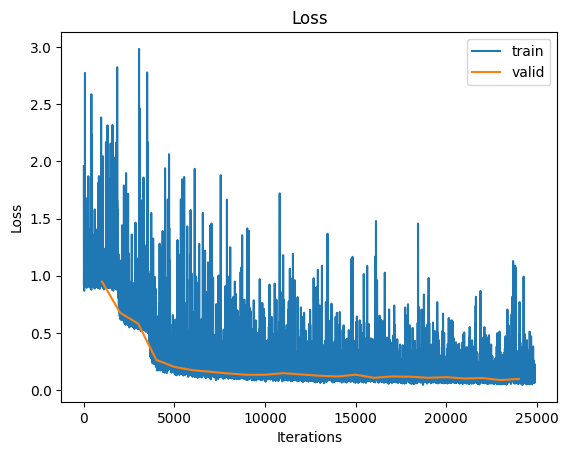

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize loss curve
plt.figure()
plt.plot(*zip(*train_loss_list), label="train")
plt.plot(*zip(*eval_loss_list), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

• Load checkpoint trained by us. 

• Do **not** run this block if you have trained your model in previous block.

In [29]:
################
## LOAD MODEL ##
################
simulator = LearnedSimulator()


simulator = simulator.cuda()


#!wget -O temp/models/WaterDrop_checkpoint.pt https://storage.googleapis.com/cs224w_course_project_dataset/Checkpoints/WaterDrop_checkpoint.pt
# checkpoint = torch.load("simulator_model_20epoch.pth")
# simulator.load_state_dict(checkpoint["model"])
# model_save_path = "simulator_model_20epoch.pth"
model_save_path = "simulator_model_justoneepoch.pth"

simulator.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

## Visualization

Since video is 1000 frames long, it might take a few minutes to rollout.

In [30]:
rollout_dataset = RolloutDataset(data_path, "valid")


simulator.eval()


rollout_data = rollout_dataset[0]


rollout_out = rollout(simulator, rollout_data, rollout_dataset.metadata, params["noise"])


rollout_out = rollout_out.permute(1, 0, 2)



/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.


/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_8783/2514391394.py:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

TYPE_TO_COLOR = {
    3: "black",
    0: "green",
    7: "magenta",
    6: "gold",
    5: "blue",
}


def visualize_prepare(ax, particle_type, position, metadata):
    bounds = metadata["bounds"]
    ax.set_xlim(bounds[0][0], bounds[0][1])
    ax.set_ylim(bounds[1][0], bounds[1][1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1.0)
    points = {type_: ax.plot([], [], "o", ms=2, color=color)[0] for type_, color in TYPE_TO_COLOR.items()}
    return ax, position, points


def visualize_pair(particle_type, position_pred, position_gt, metadata):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plot_info = [
        visualize_prepare(axes[0], particle_type, position_gt, metadata),
        visualize_prepare(axes[1], particle_type, position_pred, metadata),
    ]
    axes[0].set_title("Ground truth")
    axes[1].set_title("Prediction")

    plt.close()

    def update(step_i):
        outputs = []


        for _, position, points in plot_info:


            for type_, line in points.items():
                mask = particle_type == type_


                line.set_data(position[step_i, mask, 0], position[step_i, mask, 1])


            outputs.append(line)
        return outputs

    return animation.FuncAnimation(fig, update, frames=np.arange(0, position_gt.size(0)), interval=10, blit=True)

anim = visualize_pair(rollout_data["particle_type"], rollout_out, rollout_data["position"], rollout_dataset.metadata)
HTML(anim.to_html5_video())

MovieWriter stderr:
ffmpeg: error while loading shared libraries: libopenh264.so.5: cannot open shared object file: No such file or directory



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x500', '-pix_fmt', 'rgba', '-framerate', '100.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp8ohg_ilp/temp.m4v']' returned non-zero exit status 127.

## Conclusion

• Hope this Colab is helpful for you to understand how to apply GNN in a real-world application like simulating complex physics! 

• If you're interested in technical details, read [medium post](https://) or see [original paper](https://arxiv.org/abs/2002.09405) by DeepMind. 

• Thanks for spending your time with us!

In [ ]:
# ####################
# ## IMAGE STITCHER ## 
# ####################
# import os
# from PIL import Image

# def stitch_images_bfdh(image_folder, output_path):
#     # Load all PNG images from the folder
#     images = []
#     for filename in os.listdir(image_folder):
#         if filename.endswith('.png'):
#             img_path = os.path.join(image_folder, filename)
#             img = Image.open(img_path)
#             images.append(img)

#     # Sort images by width in descending order for better packing
#     images.sort(key=lambda img: img.width, reverse=True)

#     # Initialize variables for row-based packing
#     rows = []
#     current_row = []
#     current_width = 0
#     max_height_in_row = 0
#     max_canvas_width = 0

#     max_width = max(img.width for img in images)  # Maximum width of any image
#     max_total_height = 0

#     # Group images into rows based on width (bin-packing approach)
#     for img in images:
#         if current_width + img.width <= max_width:
#             # Add image to the current row
#             current_row.append(img)
#             current_width += img.width
#             max_height_in_row = max(max_height_in_row, img.height)
#         else:
#             # Move to the next row
#             rows.append((current_row, current_width, max_height_in_row))
#             max_canvas_width = max(max_canvas_width, current_width)
#             max_total_height += max_height_in_row
            
#             # Reset for the new row
#             current_row = [img]
#             current_width = img.width
#             max_height_in_row = img.height

#     # Add the last row
#     if current_row:
#         rows.append((current_row, current_width, max_height_in_row))
#         max_canvas_width = max(max_canvas_width, current_width)
#         max_total_height += max_height_in_row

#     # Create a new blank canvas large enough to hold all rows
#     stitched_image = Image.new('RGBA', (max_canvas_width, max_total_height))

#     # Variable to keep track of current y-position (vertical stacking)
#     y_offset = 0

#     # Stitch images row by row
#     for row, row_width, row_height in rows:
#         x_offset = 0
#         for img in row:
#             # Paste each image into its row
#             stitched_image.paste(img, (x_offset, y_offset))
#             x_offset += img.width  # Move to the right for the next image
#         y_offset += row_height  # Move down for the next row

#     # Save the stitched image
#     stitched_image.save(output_path)
#     # print(f"Stitched image saved as {output_path}")
    

# # Run stitch_images_bfdh for each item in the folders_created list
# for folder in folders_created:
#     image_folder = os.path.expanduser(os.path.join('~/Desktop/GNN/outputpng/', folder))
#     output_path = os.path.expanduser(os.path.join('~/Desktop/GNN/outputpng/', folder, f"{folder}.png"))
#     stitch_images_bfdh(image_folder, output_path)  


In [ ]:
import os
from PIL import Image

def stitch_images_bfdh(image_folder, output_path, spacing=0):
    # Load all PNG images from the folder
    images = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(image_folder, filename)
            img = Image.open(img_path)
            images.append(img)

    # Sort images by width in descending order for better packing
    images.sort(key=lambda img: img.width, reverse=True)

    # Initialize variables for row-based packing
    rows = []
    current_row = []
    current_width = 0
    max_height_in_row = 0
    max_canvas_width = 0

    max_width = max(img.width for img in images)  # Maximum width of any image
    max_total_height = 0

    # Group images into rows based on width (bin-packing approach)
    for img in images:
        if current_width + img.width + (len(current_row) * spacing) <= max_width:
            # Add image to the current row
            current_row.append(img)
            current_width += img.width
            max_height_in_row = max(max_height_in_row, img.height)
        else:
            # Move to the next row
            rows.append((current_row, current_width, max_height_in_row))
            max_canvas_width = max(max_canvas_width, current_width + (len(current_row) - 1) * spacing)
            max_total_height += max_height_in_row + spacing

            # Reset for the new row
            current_row = [img]
            current_width = img.width
            max_height_in_row = img.height

    # Add the last row
    if current_row:
        rows.append((current_row, current_width, max_height_in_row))
        max_canvas_width = max(max_canvas_width, current_width + (len(current_row) - 1) * spacing)
        max_total_height += max_height_in_row  # Don't add spacing after the last row

    # Create a new blank canvas large enough to hold all rows
    stitched_image = Image.new('RGBA', (max_canvas_width, max_total_height))

    # Variable to keep track of current y-position (vertical stacking)
    y_offset = 0

    # Stitch images row by row
    for row, row_width, row_height in rows:
        x_offset = 0
        for img in row:
            # Paste each image into its row with spacing
            stitched_image.paste(img, (x_offset, y_offset))
            x_offset += img.width + spacing  # Move to the right for the next image
        y_offset += row_height + spacing  # Move down for the next row with spacing

    # Save the stitched image
    stitched_image.save(output_path)
    # print(f"Stitched image saved as {output_path}")

# Run stitch_images_bfdh for each item in the folders_created list
for folder in folders_created:
    image_folder = os.path.expanduser(os.path.join('~/Desktop/GNN/outputpng/', folder))
    output_path = os.path.expanduser(os.path.join('~/Desktop/GNN/outputpng/', folder, f"{folder}.png"))
    stitch_images_bfdh(image_folder, output_path, spacing=10)

# outputfile = r"C:\Users\Admin\Desktop\GNNoutputpng\OneStepDataset\outputpng.png"
# # if outputfile exists then delete it
# if os.path.exists(outputfile):
#     os.remove(outputfile)  # Remove the file
#     # print(f"File '{outputfile}' has been removed.")
# else:
#     # print(f"File '{outputfile}' does not exist.")

# image_folder = r'C:\Users\Admin\Desktop\GNNoutputpng\OneStepDataset'
# stitch_images_bfdh(image_folder, outputfile, spacing=10)  # Example with 10px spacing
